# Factors

## A: Standard Scaling (applied or not applied)

## B: PCA to 10 dimensions (applied or not applied)

## C: Transformation from 2D image to 1D vector (just row by row or randomly, but with a fixed random way)

## D: Model type (DecisionTreeClassifier or LogisticRegression)

# Response variable

## Accuracy

# The task

Training a classifier on a MNIST dataset

## MNIST

something something a classic benchmark for machine learning classification and more, proposed by Yann Le Cun etc. [Nice picture etc.]

# Setting

## Train test split approach

60k vs 10k (following paper by Le Cun), a single split to maintain comparability between experiments (i.e. train set and test set are always the same)

## Classifiers

Default configuration, this type of experiment makes playing aroung with hyperparameters a bit problematic

In [15]:
from sklearn.datasets import fetch_openml

try:
    X = pd.read_csv('data/X.csv', index_col=0)
    y = pd.read_csv('data/y.csv', index_col=0)
except:
    X, y = fetch_openml('mnist_784', data_home='data', version=1, return_X_y=True)

In [7]:
import matplotlib.pyplot as plt

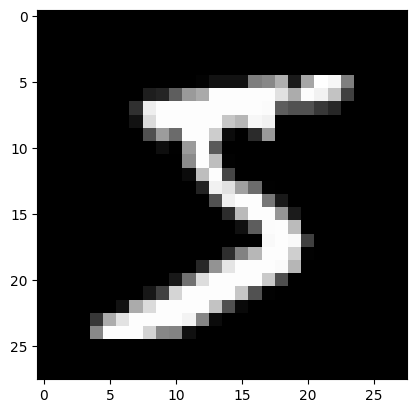

In [17]:
plt.imshow(X.values.reshape(-1, 28, 28)[0], cmap="gray");

In [18]:
from sklearn.model_selection import train_test_split
def train_test_data(X, y, test_size=10_000, seed=123):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    return X_train.values, X_test.values, y_train.values, y_test.values

In [19]:
from sklearn.preprocessing import StandardScaler
def standard_scaling(X_train, X_test, apply):
    if apply:
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)
    return X_train, X_test

In [20]:
from sklearn.decomposition import PCA
def pca(X_train, X_test, apply, n_components=10):
    if apply:
        pca = PCA(n_components=n_components)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    return X_train, X_test

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
def train_model(X_train, y_train, model):
    if model:
        clf = LogisticRegression(random_state=123)
    else:
        clf = DecisionTreeClassifier(random_state=123)
    clf.fit(X_train, y_train)
    return clf
    

In [22]:
import numpy as np
def get_random_shuffle(X_train, y_train, X_test, y_test, apply, seed=123):
    if apply:
        np.random.seed(seed)
        idx = np.random.permutation(X_train.shape[1])
        X_train = X_train[:, idx]
        X_test = X_test[:, idx]
    return X_train, y_train, X_test, y_test

In [23]:
def evaluate(X_test, y_test, clf):
    return clf.score(X_test, y_test)

In [24]:
def run_single(X_train, X_test, y_train, y_test, A, B, C, D):
    X_train, X_test = standard_scaling(X_train, X_test, apply=A)
    X_train, X_test = pca(X_train, X_test, apply=B)
    X_train, y_train, X_test, y_test = get_random_shuffle(X_train, y_train, X_test, y_test, apply=C)
    clf = train_model(X_train, y_train, model=D)
    return evaluate(X_test, y_test, clf)

In [50]:
import itertools
import pandas as pd
from tqdm import tqdm

import multiprocessing

class SingleRunProcess(multiprocessing.Process):
    def __init__(self, X_train, X_test, y_train, y_test, A, B, C, D, results_q):
        multiprocessing.Process.__init__(self)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.results_q = results_q

    def run(self):
        score = run_single(self.X_train, self.X_test, self.y_train, self.y_test, self.A, self.B, self.C, self.D)
        self.results_q.put([self.A, self.B, self.C, self.D, score])



In [ ]:


def run():
    X_train, X_test, y_train, y_test = train_test_data(X, y)
    results = []
    results_q = multiprocessing.Queue()
    factors = ["A", "B", "C", "D"]
    response = ["Y"]
    for A, B, C, D in tqdm(itertools.product([True, False], repeat=4)):
        p = SingleRunProcess(X_train, X_test, y_train, y_test, A, B, C, D, results_q)
        p.start()
    
    for _ in tqdm(range(2 ** 4)):
        p.join()
        results.append(results_q.get())
    df = pd.DataFrame(results, columns=factors + response)
    df[factors] = df[factors].applymap(lambda x: {True: 1, False: -1}[x])
    for comb_size in range(1, len(factors) + 1):
        for comb in itertools.combinations(factors, comb_size):
            df["".join(comb)] = df[list(comb)].prod(axis=1)
        
    df = df[[c for c in df.columns if c != "Y"] + ["Y"]]
    return df

In [ ]:
def save_results(df):
    df.to_csv("data/results.csv")

In [51]:
df = pd.read_csv("data/results.csv", index_col=0)

In [52]:
df

,A,B,C,D,AB,AC,AD,BC,BD,CD,ABC,ABD,ACD,BCD,ABCD,Y
0,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,0.9213
1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,0.8749
2,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,0.7973
3,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,0.7973
4,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,0.8236
5,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,0.8247
6,1,1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,1,1,1,0.8222
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.7967
8,1,1,1,-1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1,0.8228
9,1,1,-1,1,1,-1,1,-1,1,-1,-1,1,-1,-1,-1,0.7967


In [53]:
X_, Y_ = df[[c for c in df.columns if c != "Y"]].values, df["Y"].values

In [54]:
beta_hat = 1/X_.shape[0] * X_.T @ Y_

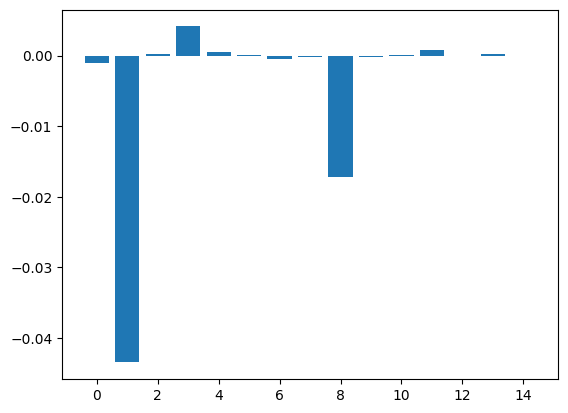

In [59]:
plt.bar(range(len(beta_hat)), beta_hat);